In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from utilidades import load_data,get_mean_af
from sklearn.cluster import KMeans
from functools import reduce
from sklearn.metrics import silhouette_score

In [3]:
# GAP Statistic function
def compute_inertia(a, X):
    from sklearn.metrics import pairwise_distances
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max=5, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))
    
    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))
        
    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

In [4]:
afs=load_data()
pre_a=afs['af_ye']
a=pre_a.rename(columns={'Unnamed: 0':'country','Unnamed: 1':'date'})

In [5]:
antifs=[]
for name, antif in afs.items():
    antif.columns = ['country','date','af_in_pr_'+name[2:],'af_in_vl'+name[2:],'af_ex_pr'+name[2:],'af_ex_vl'+name[2:], 'af_in_pr2'+name[2:],
                    'af_in_pr2'+name[2:], 'af_ex_pr2'+name[2:],'af_ex_vl2'+name[2:]]
    antifs.append(antif)

In [6]:
result=reduce(lambda df1,df2: df1.merge(df2,how='inner',on=['country','date']),antifs)

In [7]:
result=result.dropna(axis=0)

In [8]:
_A=result.groupby(['country']).mean().drop(columns='date')

In [9]:
_A = a.groupby('country').mean().drop(columns='date')

In [10]:
_A = _A.dropna()

In [11]:
RANDOM_STATE=1

### PCA

In [12]:
pca = PCA(n_components=.95,random_state=RANDOM_STATE).fit(_A)
_A_projected=pca.transform(_A)

In [13]:
np.cumsum(pca.explained_variance_ratio_)

array([0.65998514, 0.87645817, 0.94086129, 0.97949165])

In [14]:
pca.n_components_

4

<AxesSubplot:>

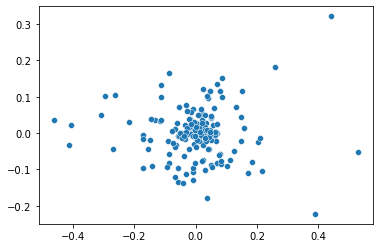

In [131]:
sns.scatterplot(x=_A_projected[:,0],y=_A_projected[:,1])

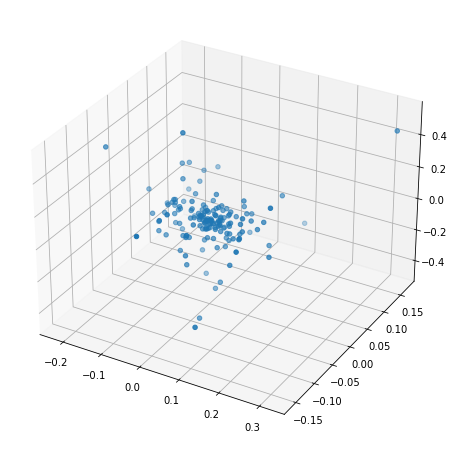

In [132]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
# Data for three-dimensional scattered points
zdata = _A_projected[:,0]
xdata = _A_projected[:,1]
ydata = _A_projected[:,2]
ax.scatter3D(xdata, ydata, zdata)

### GAP Statistic --- Estimating number of clusters

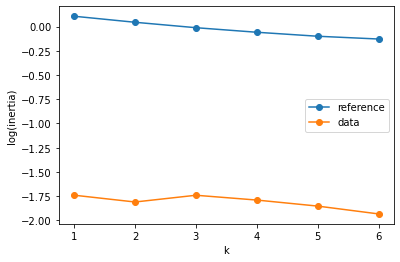

Text(0.5, 0, 'k')

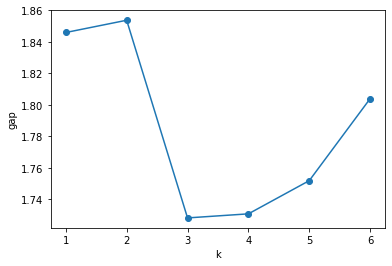

In [149]:
k_max = 6
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(random_state=RANDOM_STATE,n_init=100), _A_projected, k_max)


plt.plot(range(1, k_max+1), reference_inertia,
         '-o', label='reference')
plt.plot(range(1, k_max+1), ondata_inertia,
         '-o', label='data')
plt.xlabel('k')
plt.ylabel('log(inertia)')
plt.legend()
plt.show()

plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

## KMeans

In [159]:
cluster = KMeans(n_clusters=2,random_state=RANDOM_STATE,n_init=100).fit(_A_projected)
ys=cluster.labels_

grupos_km = pd.DataFrame({'country':_A.index.values,'grupo':ys})

In [162]:
# grupos_km.pivot(columns='grupo').to_excel('~/ver_clusters_v2.xlsx')

In [152]:
grupos_km=grupos_km.set_index('country')

<AxesSubplot:xlabel='grupo'>

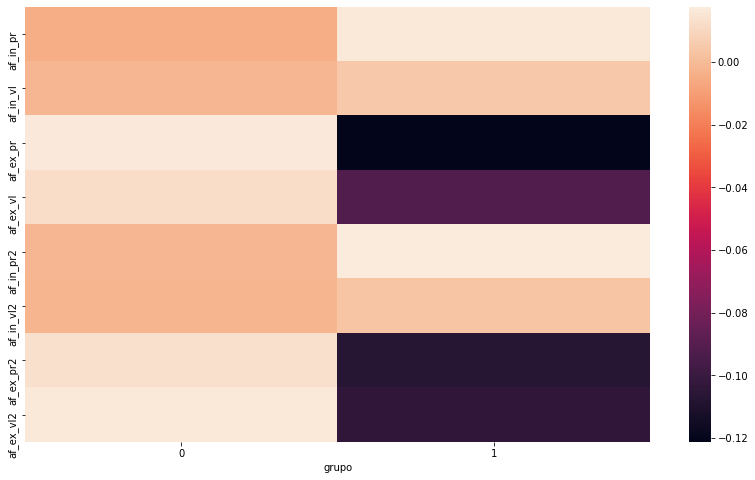

In [153]:
plt.figure(figsize=(14,8))
sns.heatmap(_A.join(grupos_km).groupby('grupo').mean().T)

In [155]:
grupos_km[grupos_km['grupo']==1]

,grupo
country,
Algeria,1
Botswana,1
Cape Verde,1
"China, Macao SAR",1
Dominica,1
Ethiopia,1
Gabon,1
Georgia,1
Grenada,1
